# Star Wars Episode V Analysis

This analysis dives into the script from Star Wars Episode V: *The Empire Strikes Back*.

Source: https://www.kaggle.com/datasets/xvivancos/star-wars-movie-scripts?select=SW_EpisodeV.txt

## Data Cleaning

- Skip first line: *"character" "dialogue"*
- Lowercase each letter and split by quotes
- Create a dictionary, where each line is split by line number, name of character and dialouge. Dictionary is stored in a list.

A list is returned containing each individual line separated by line number, character name, and the dialouge. Each line is then separated by curly brackets.

In [132]:
sw_dic = []

with open("SW_EpisodeV.txt", "r") as text:
    """    
    Returns a list containing each line separately
    
    Each line is split into line number, character name, and dialogue

    Input:
        A text file

    Output:
        A dictionary containing line number, character name and dialogue
    """
    text = text.readlines()[1:]  #skip first line
    for line in text:
        line = line.lower().split('"') #lowercase and split by quotes
        if len(line) > 5:
            try:
                dialogue = line.pop(5)
                name = line.pop(3)
                #line_number = line.pop(1)
                new_obj = {
                    #"line": line_number.strip(),
                    "name": name.strip(),
                    "dialogue": dialogue.strip()
                }
                sw_dic.append(new_obj)
            except IndexError:
                continue

## Data Analysis

This analysis utilizes the Natural Language Toolkit. For this project, I downloaded the most popular.

Analysis includes
- finding how many lines each character speaks
- finding the most active character
- finding the top 3 most active characters
- sentiment analysis
- find the 20 most common words

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [72]:
#nltk.download('stopwords', force=True)
#nltk.download('punkt_tab')

#### Character Frequency

A numpy.ndarray containing of all the character names is created and stored in a list. Counter is used to calculate how many lines each character had which is stored in a dictionary.

In [75]:
arr = np.array(sw_dic) #numpy.ndarray contianing all character names

name_column = [row['name'] for row in arr] #list of all names

name_freq = dict(Counter(name_column)) #store in a dictionary

sorted_name_freq = dict(sorted(name_freq.items(), key=lambda item:item[1], reverse=True)) #sorts in descending order

print(sorted_name_freq)

{'han': 182, 'luke': 128, 'leia': 114, 'threepio': 92, 'lando': 61, 'vader': 56, 'yoda': 36, 'piett': 23, 'creature': 21, 'ben': 15, 'rieekan': 13, 'wedge': 8, 'deck officer': 7, 'veers': 7, 'zev': 6, 'ozzel': 5, 'needa': 5, 'emperor': 5, 'dack': 4, 'janson': 4, 'boba fett': 4, 'derlin': 3, 'announcer': 3, 'controller': 3, 'trench officer': 3, 'lieutenant': 2, 'senior controller': 2, 'medical droid': 2, 'imperial officer': 2, 'tracking officer': 2, 'communications officer': 2, 'intercom voice': 2, 'assistant officer': 1, 'rebel captain': 1, 'rebel fighter': 1, 'hobbie': 1, 'pilots': 1, 'captain': 1, 'woman controller': 1, 'head controller': 1, 'officer': 1, 'second officer': 1, 'pilot': 1, 'strange voice': 1, 'first controller': 1, 'second controller': 1, 'second threepio': 1, 'man': 1, 'imperial soldier': 1}


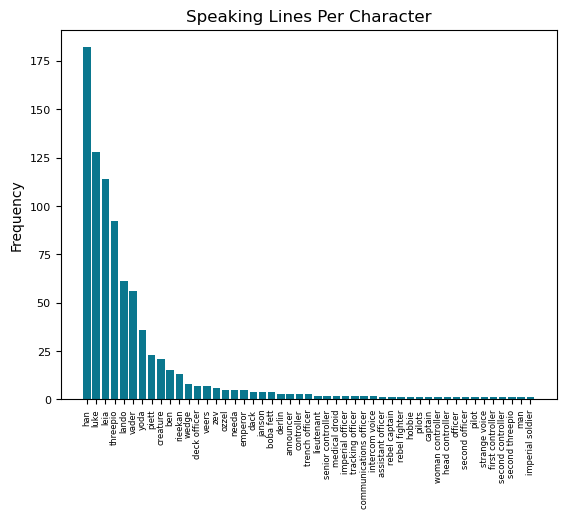

In [77]:
Character = sorted_name_freq.keys() #return the keys (character names)
Frequency = sorted_name_freq.values() #return the values (number of lines)

#bar chart comparing characters and the number of lines they have
plt.bar(Character, Frequency, color=['#0a778e'])
plt.title('Speaking Lines Per Character')
plt.xlabel('', labelpad= -10)
plt.xticks(rotation = 'vertical')
plt.xticks(fontsize= 6)
plt.ylabel('Frequency')
plt.yticks(fontsize = 8)
plt.savefig("images/num_character_lines.png", bbox_inches='tight')
plt.show()

#### Most Active Character
This function returns the character with the most speaking lines.

In [106]:
def most_frequent(name_column):
    """
    Returns the character who has the most speaking lines
    """
    counter = 0
    num = name_column[0]
    for i in name_column:
        freq = name_column.count(i)
        if(freq>counter):
            counter = freq
            num = i
    return num

print("The most active character in this episode is: ",most_frequent(name_column))

The most active character in this episode is:  han


#### The Top Three Characters
Find the 3 characters that have the most speaking lines.

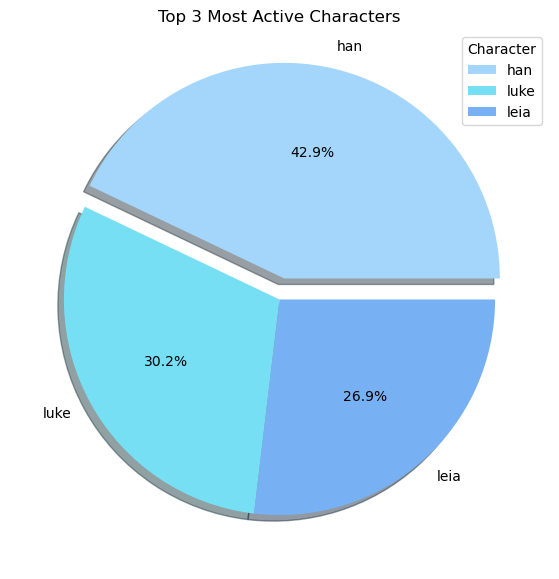

In [100]:
top_three = sorted(name_freq.items(), key=lambda item: item[1], reverse=True)[:3]

labels = [item[0] for item in top_three]
slices = [item[1] for item in top_three]

mycolors = ["#a3d6fa", "#77dff3", "#77b1f3"]
myexplode = (0.1, 0, 0)

fig = plt.figure(figsize=(10, 7))
plt.pie(
    slices,
    labels=labels,
    autopct='%1.1f%%',
    shadow=True,
    colors=mycolors,
    explode=myexplode
)
plt.title("Top 3 Most Active Characters")
plt.legend(title="Character")
plt.savefig("images/top_3_char.png", bbox_inches='tight')
plt.show()


### Sentiment Analysis
Using VADER's sentiment analyzer, this analyzer returns a dictionary of sentiment scores for each of the string inputs, in this case, character names. Choosing any characters, determine how positive, negative, or neutral their character is throughout the episode.

In [109]:
from collections import defaultdict
from nltk.sentiment import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

In [113]:
char_dialogue = defaultdict(list)

for entry in sw_dic:
     #converts names to lowercase and appends their dialogue
    #returns a dictionary
    char_dialogue[entry['name'].lower()].append(entry['dialogue'])

In [130]:
analyzer = SentimentIntensityAnalyzer() #VADERs sentiment analyzer

def analyze_char_sentiment(name):
    """
    Analyzes and returns the sentiment for the character and all their dialogue lines.

    The analyzer.polarity_scores determines the sentiment line-by-line and then averages them
    The compound score is normalized sentiment from -1 (negative) to +1 (positive)

    The function will assign a sentiment Label:
        >= 0.05 means positive
        <= 0,05 means negative
        else means neutral
        
    Input:
        character name (str)
        
    Output:
        Returns a string
        The character, sentiment label, average sentiment score and number of lines analyzed
        If the character does not exist or does not speak, it will inform the user.

    """
    name = name.lower() #converts name to lowercase
    lines = char_dialogue.get(name, []) #looks up in dictionary
    if not lines:
        return f"{name.title()} is either not in this episode or has no dialogue."

    scores = [analyzer.polarity_scores(line)['compound'] for line in lines] #determine sentiment
    avg = sum(scores) / len(scores) #average sentiment scores across all lines

    # Determine sentiment label
    if avg >= 0.05:
        sentiment = "positive"
    elif avg <= -0.05:
        sentiment = "negative"
    else:
        sentiment = "neutral"

    return f"{name.title()} is {sentiment} (avg sentiment = {avg:.2f}, lines analyzed = {len(lines)})"
    
hans_sentiment = analyze_char_sentiment('han')
lukes_sentiment = analyze_char_sentiment('luke')
chewies_sentiment = analyze_char_sentiment('chewbacca')

print(hans_sentiment)
print(lukes_sentiment)
print(chewies_sentiment)

Han is positive (avg sentiment = 0.12, lines analyzed = 182)
Luke is neutral (avg sentiment = 0.03, lines analyzed = 128)
Chewbacca is either not in this episode or has no dialogue.


#### Most Commonly Used Words

A numpy.ndarray of all the dialogue is created and stored in a list. All punctuation and stopwords are removed.

In [121]:
dialogue_arr = np.array(sw_dic) #numpy.ndarray contianing all dialogue

char_lines = [row['dialogue'] for row in dialogue_arr] #list containing all dialogue

excluded = set(string.punctuation) #remove outer punctuation
char_lines = ' '.join(ch for ch in char_lines if ch not in excluded)
    
punc = '''!()-[]{};:'",<>./?@#$%^&*_~''' #remove additional punctuation
no_punct = " "
for char_punc in char_lines:
    if char_punc not in punc:
        no_punct = no_punct + char_punc
no_punct = no_punct

In [123]:
def remove_stopwords(script):
    """
    Returns a list ofeach word in script, excluding stopwords
    """
    stopWords = set(stopwords.words('english')) #define the stopwords using NLTK
    words = word_tokenize(script)
    filtered = [w for w in words if w.lower() not in stopWords]
    return filtered

cleaned = remove_stopwords(no_punct)

Find the 20 most common words.

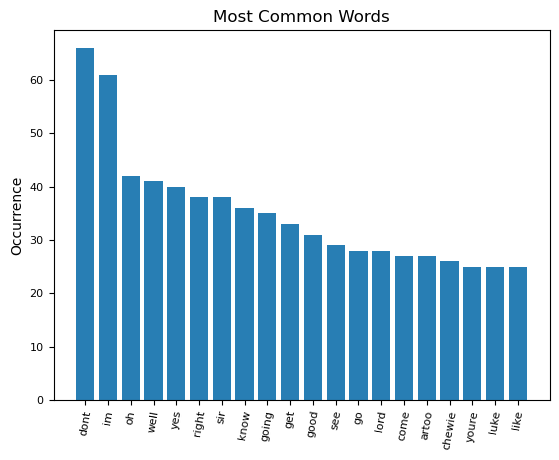

In [126]:
count_per_word = Counter(cleaned)  #count occurrences of each word

most_common_words = count_per_word.most_common(20) #return top 20

#separate the list of tuples into separate lists for words and their counts
most_freq_words = [word for word, _ in most_common_words]
occurrence_of_word = [count for _, count in most_common_words]

plt.bar(most_freq_words, occurrence_of_word, color=['#287eb4'])
plt.title('Most Common Words')
plt.xlabel('', labelpad=-4)
plt.xticks(rotation=80)
plt.xticks(fontsize=8)
plt.ylabel('Occurrence')
plt.yticks(fontsize=8)
plt.savefig("images/most_common_words.png", bbox_inches='tight')
plt.show()

#### Conclusion
This project analyzes the script from Star Wars Episode V: *The Empire Strikes Back* sourced from Kaggle. 

Among all characters, Han Solo had the most speaking lines, followed by Luke SKywalker and Princess Leia. Sentiment analysis was conducted for three selected characters: Han, Luke and Chewbacca. Han's dialogue showed a positive sentiment while Luke's was neutral.Chewbacca had no speaking lines, making the sentiment analysis inapplicable for him. After filtering out the stopwords, the 20 most frequently used words were identified. The most common word was "don't". The name "Luke" also appeared among the top words, which is expected given his key role in the story. Notably, names like "Artoo" and "Chewie" also made the list, highlighting their memorable presence in the film.